<a href="https://colab.research.google.com/github/AlfredoLobosC/03MIAR_algoritmos_de_optimizacion/blob/main/ALC_python_miar_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introducción (versión breve para el notebook)
El presente trabajo utiliza datos oficiales del Ministerio de Educación de Chile (Mineduc), específicamente los registros administrativos publicados por el Centro de Estudios del Mineduc (CEM). Estas bases contienen información detallada sobre establecimientos educacionales, matrícula y asistencia mensual de estudiantes en el sistema escolar chileno.

El problema que motiva este análisis es la importancia de la asistencia escolar como indicador temprano de riesgo de desvinculación. Diversos estudios del CEM muestran que la inasistencia reiterada es uno de los predictores más fuertes de abandono escolar, por lo que contar con datos limpios, integrados y analizables es fundamental para apoyar la toma de decisiones educativas.

En este proyecto se construye un dataset Gold a partir de tres fuentes principales:

Asistencia Mensual 2023, con días asistidos y trabajados por estudiante y establecimiento.

Matrícula 2023, con información académica y administrativa del establecimiento.

Directorio de Establecimientos, con datos institucionales como nombre y dependencia.

El objetivo es transformar estas fuentes en un dataset unificado, consistente y listo para análisis, siguiendo un proceso ETL estructurado (Bronze → Silver → Gold). El resultado permite explorar patrones de asistencia, diferencias por dependencia y variabilidad entre establecimientos, constituyendo una base sólida para estudios posteriores sobre permanencia escolar.

# Construcción de un Dataset Gold de Asistencia Escolar (Trabajo 01MIAR)

## Objetivo

El objetivo de este trabajo es construir un dataset **Gold** a partir de datos educativos reales, aplicando un proceso ETL clásico:

- **Bronze:** carga y limpieza de datos.
- **Silver:** transformación y cálculo de métricas de asistencia.
- **Gold:** integración con información de matrícula y directorio de establecimientos.

Datasets utilizados:

- **Asistencia 2023** (con `DIAS_ASISTIDOS`, `DIAS_TRABAJADOS`, `ASIS_PROMEDIO`).
- **Matrícula 2023** (sin `MRUN`).
- **Directorio de establecimientos 2023`.

El objetivo no es procesar todo el sistema educativo, sino mostrar con claridad un flujo ETL completo y bien documentado.



In [49]:
import pandas as pd
import numpy as np
import os

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)


## Carga de datos desde Google Drive

Para asegurar que los archivos utilizados en este proyecto estén disponibles de forma persistente y organizada, montamos Google Drive en Colab.




In [31]:
# 1. Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/miar_datos"

# 3. Definir rutas completas a los archivos
ruta_asistencia = f"{base_path}/asistencia_marzo_2023.csv"
ruta_matricula  = f"{base_path}/20230925_Resumen_Matricula_EE_Oficial_2023_20230430_WEB.csv"
ruta_directorio = f"{base_path}/20230912_Directorio_Oficial_EE_2023_20230430_WEB.csv"

print("Rutas configuradas:")
print(ruta_asistencia)
print(ruta_matricula)
print(ruta_directorio)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Rutas configuradas:
/content/drive/MyDrive/miar_datos/asistencia_marzo_2023.csv
/content/drive/MyDrive/miar_datos/20230925_Resumen_Matricula_EE_Oficial_2023_20230430_WEB.csv
/content/drive/MyDrive/miar_datos/20230912_Directorio_Oficial_EE_2023_20230430_WEB.csv


## ETAPA BRONZE — Carga y limpieza básica

En esta etapa:

- Cargamos los archivos fuente desde Google Drive.
- Eliminamos el BOM de los CSV (si existe).
- Normalizamos nombres de columnas.
- Convertimos tipos básicos (`AGNO`, `MES_ESCOLAR`, `RBD`, métricas de asistencia).
- Definimos una función para limpiar `MRUN` en el dataset de asistencia.

In [50]:
def limpiar_mrun(serie):
    s = serie.astype(str).str.strip()
    s = s.str.replace(r"\D", "", regex=True)  # elimina todo lo no numérico
    s = s.str.zfill(9)                        # rellena con ceros a la izquierda
    return s


In [51]:
df_asistencia = pd.read_csv(
    ruta_asistencia,
    sep=";",
    dtype=str,
    encoding="utf-8-sig"   # elimina BOM si existe
)

# Normalizar nombres de columnas
df_asistencia.columns = (
    df_asistencia.columns
    .str.replace("ï»¿", "", regex=False)
    .str.strip()
    .str.upper()
)

df_asistencia.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3361115 entries, 0 to 3361114
Data columns (total 27 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   AGNO             object
 1   MES_ESCOLAR      object
 2   RBD              object
 3   DGV_RBD          object
 4   NOM_RBD          object
 5   COD_REG_RBD      object
 6   NOM_REG_RBD_A    object
 7   COD_PRO_RBD      object
 8   COD_COM_RBD      object
 9   NOM_COM_RBD      object
 10  COD_DEPROV_RBD   object
 11  NOM_DEPROV_RBD   object
 12  RURAL_RBD        object
 13  COD_DEPE         object
 14  COD_DEPE2        object
 15  COD_ENSE         object
 16  COD_ENSE2        object
 17  COD_GRADO        object
 18  LET_CUR          object
 19  MRUN             object
 20  GEN_ALU          object
 21  FEC_NAC_ALU      object
 22  COD_COM_ALU      object
 23  NOM_COM_ALU      object
 24  DIAS_ASISTIDOS   object
 25  DIAS_TRABAJADOS  object
 26  ASIS_PROMEDIO    object
dtypes: object(27)
memory usage: 692.4+ MB


,AGNO,MES_ESCOLAR,RBD,DGV_RBD,NOM_RBD,COD_REG_RBD,NOM_REG_RBD_A,COD_PRO_RBD,COD_COM_RBD,NOM_COM_RBD,COD_DEPROV_RBD,NOM_DEPROV_RBD,RURAL_RBD,COD_DEPE,COD_DEPE2,COD_ENSE,COD_ENSE2,COD_GRADO,LET_CUR,MRUN,GEN_ALU,FEC_NAC_ALU,COD_COM_ALU,NOM_COM_ALU,DIAS_ASISTIDOS,DIAS_TRABAJADOS,ASIS_PROMEDIO
0,2023,3,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,ARICA,0,6,5,463,8,3,A,2090398,1,198303,15101,ARICA,0,13,0
1,2023,3,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,ARICA,0,6,5,463,8,3,A,4360702,2,198207,15101,ARICA,13,13,1
2,2023,3,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,ARICA,0,6,5,463,8,3,A,8284609,2,200410,15101,ARICA,13,13,1
3,2023,3,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,ARICA,0,6,5,463,8,3,A,8481824,2,198509,15101,ARICA,13,13,1
4,2023,3,1,9,LICEO POLITECNICO ARICA,15,AYP,151,15101,ARICA,151,ARICA,0,6,5,463,8,3,A,14639657,2,200401,15101,ARICA,13,13,1


In [52]:
# conversión de tipos en asistencia

df_asistencia["AGNO"] = pd.to_numeric(df_asistencia["AGNO"], errors="coerce").astype("Int32")
df_asistencia["MES_ESCOLAR"] = pd.to_numeric(df_asistencia["MES_ESCOLAR"], errors="coerce").astype("Int32")

# Conversión de RBD
df_asistencia["RBD"] = pd.to_numeric(df_asistencia["RBD"], errors="coerce").astype("Int32")

# Conversión de métricas de asistencia
for col in ["DIAS_ASISTIDOS", "DIAS_TRABAJADOS", "ASIS_PROMEDIO"]:
    if col in df_asistencia.columns:
        df_asistencia[col] = pd.to_numeric(df_asistencia[col], errors="coerce").astype("Float64")

# Limpieza de MRUN (solo en asistencia)
if "MRUN" in df_asistencia.columns:
    df_asistencia["MRUN"] = limpiar_mrun(df_asistencia["MRUN"])

df_asistencia[["AGNO", "MES_ESCOLAR", "RBD", "MRUN", "DIAS_ASISTIDOS", "DIAS_TRABAJADOS"]].head()


,AGNO,MES_ESCOLAR,RBD,MRUN,DIAS_ASISTIDOS,DIAS_TRABAJADOS
0,2023,3,1,002090398,0.0,13.0
1,2023,3,1,004360702,13.0,13.0
2,2023,3,1,008284609,13.0,13.0
3,2023,3,1,008481824,13.0,13.0
4,2023,3,1,014639657,13.0,13.0


In [54]:
# Filtar Marzo 2023
df_marzo = df_asistencia.query("AGNO == 2023 and MES_ESCOLAR == 3").copy()

print("Filas en df_marzo:", len(df_marzo))
df_marzo[["AGNO", "MES_ESCOLAR"]].drop_duplicates()


/tmp/ipython-input-3950070948.py:2: RuntimeWarning: Engine has switched to 'python' because numexpr does not support extension array dtypes. Please set your engine to python manually.
  df_marzo = df_asistencia.query("AGNO == 2023 and MES_ESCOLAR == 3").copy()


Filas en df_marzo: 3361115


,AGNO,MES_ESCOLAR
0,2023,3


En la etapa Bronze hemos:

- Cargado el dataset de asistencia 2023 desde Google Drive.
- Eliminado el BOM y normalizado los nombres de columnas.
- Convertido tipos clave (`AGNO`, `MES_ESCOLAR`, `RBD`, métricas de asistencia).
- Estandarizado el identificador `MRUN` en el dataset de asistencia.
- Filtrado el subconjunto correspondiente a marzo de 2023 (`df_marzo`).

Pasamos ahora a la etapa Silver, donde agregaremos la información a nivel de estudiante y establecimiento.


## ETAPA SILVER — Transformación y cálculo de métricas

Objetivo:

- Construir un dataset de asistencia a nivel de estudiante y establecimiento para marzo 2023.
- Calcular métricas agregadas:
  - `DIAS_ASISTIDOS`
  - `DIAS_TRABAJADOS`
  - `ASISTENCIA_PCT`


In [55]:
group_cols = ["AGNO", "MES_ESCOLAR", "RBD", "MRUN"]

agg_dict = {
    "DIAS_ASISTIDOS": "sum",
    "DIAS_TRABAJADOS": "sum"
}

df_silver = (
    df_marzo
    .groupby(group_cols, dropna=False)
    .agg(agg_dict)
    .reset_index()
)

df_silver["ASISTENCIA_PCT"] = (
    df_silver["DIAS_ASISTIDOS"] / df_silver["DIAS_TRABAJADOS"]
) * 100

print("Filas en df_silver:", len(df_silver))
df_silver.head()


Filas en df_silver: 3350832


,AGNO,MES_ESCOLAR,RBD,MRUN,DIAS_ASISTIDOS,DIAS_TRABAJADOS,ASISTENCIA_PCT
0,2023,3,1,000016158,14.0,19.0,73.684211
1,2023,3,1,000020439,13.0,19.0,68.421053
2,2023,3,1,000032040,12.0,13.0,92.307692
3,2023,3,1,000149775,8.0,19.0,42.105263
4,2023,3,1,000362163,16.0,19.0,84.210526


In [56]:
# Chequeando Silver
print("Proporción de nulos por columna:")
print(df_silver.isna().mean())

df_silver[["DIAS_ASISTIDOS", "DIAS_TRABAJADOS", "ASISTENCIA_PCT"]].describe()


Proporción de nulos por columna:
AGNO               0.0
MES_ESCOLAR        0.0
RBD                0.0
MRUN               0.0
DIAS_ASISTIDOS     0.0
DIAS_TRABAJADOS    0.0
ASISTENCIA_PCT     0.0
dtype: float64


,DIAS_ASISTIDOS,DIAS_TRABAJADOS,ASISTENCIA_PCT
count,3350832.0,3350832.0,3350832.0
mean,18.25115,20.795182,<NA>
std,4.087901,1.755559,<NA>
min,0.0,0.0,<NA>
25%,17.0,21.0,<NA>
50%,20.0,21.0,<NA>
75%,21.0,21.0,<NA>
max,23.0,84.0,<NA>


En la etapa Silver hemos obtenido un dataset de asistencia a nivel de estudiante y establecimiento para marzo 2023:

- Una fila por combinación (`AGNO`, `MES_ESCOLAR`, `RBD`, `MRUN`).
- Días asistidos y trabajados agregados.
- Porcentaje de asistencia calculado.

Este dataset será la base para la integración con matrícula y directorio en la etapa Gold.


## ETAPA GOLD — Integración con Matrícula y Directorio

Objetivo:

- Enriquecer el dataset Silver con información de matrícula (nivel, curso).
- Incorporar información del directorio de establecimientos (nombre, dependencia).
- Obtener un dataset final listo para análisis.

El match entre datasets se realizará por **RBD** (establecimiento).


In [57]:
# carga y limpieza de matrícula
df_mat = pd.read_csv(
    ruta_matricula,
    sep=";",
    dtype=str,
    encoding="utf-8-sig"
)

df_mat.columns = (
    df_mat.columns
    .str.replace("ï»¿", "", regex=False)
    .str.strip()
    .str.upper()
)

df_mat["RBD"] = pd.to_numeric(df_mat["RBD"], errors="coerce").astype("Int32")

cols_mat_keep = ["AGNO", "RBD", "COD_ENSE", "COD_GRADO", "LET_CUR"]
cols_mat_keep = [c for c in cols_mat_keep if c in df_mat.columns]

df_mat_sel = df_mat[cols_mat_keep].copy()

df_mat_sel.head()


,AGNO,RBD
0,2023,1
1,2023,2
2,2023,3
3,2023,4
4,2023,5


In [58]:
# carga y limpieza de directorio
df_dir = pd.read_csv(
    ruta_directorio,
    sep=";",
    dtype=str,
    encoding="utf-8-sig"
)

df_dir.columns = (
    df_dir.columns
    .str.replace("ï»¿", "", regex=False)
    .str.strip()
    .str.upper()
)

df_dir["RBD"] = pd.to_numeric(df_dir["RBD"], errors="coerce").astype("Int32")

cols_dir_keep = ["RBD", "NOM_RBD", "COD_DEPE"]
cols_dir_keep = [c for c in cols_dir_keep if c in df_dir.columns]

df_dir_sel = df_dir[cols_dir_keep].copy()

df_dir_sel.head()


,RBD,NOM_RBD,COD_DEPE
0,1,LICEO POLITECNICO ARICA,6
1,2,PARVULARIO LAS ESPIGUITAS,6
2,3,ESC. PEDRO VICENTE GUTIERREZ TORRES,6
3,4,LICEO OCTAVIO PALMA PEREZ,6
4,5,JOVINA NARANJO FERNANDEZ,6


In [59]:
# merge Silver + Matrícula (por RBD)
df_gold = df_silver.merge(
    df_mat_sel,
    on="RBD",
    how="left",
    validate="m:1"   # muchos registros de asistencia por establecimiento
)

df_gold.head()


,AGNO_x,MES_ESCOLAR,RBD,MRUN,DIAS_ASISTIDOS,DIAS_TRABAJADOS,ASISTENCIA_PCT,AGNO_y
0,2023,3,1,000016158,14.0,19.0,73.684211,2023
1,2023,3,1,000020439,13.0,19.0,68.421053,2023
2,2023,3,1,000032040,12.0,13.0,92.307692,2023
3,2023,3,1,000149775,8.0,19.0,42.105263,2023
4,2023,3,1,000362163,16.0,19.0,84.210526,2023


In [60]:
# merge con Directorio (por RBD)
df_gold = df_gold.merge(
    df_dir_sel,
    on="RBD",
    how="left",
    validate="m:1"
)

df_gold.head()


,AGNO_x,MES_ESCOLAR,RBD,MRUN,DIAS_ASISTIDOS,DIAS_TRABAJADOS,ASISTENCIA_PCT,AGNO_y,NOM_RBD,COD_DEPE
0,2023,3,1,000016158,14.0,19.0,73.684211,2023,LICEO POLITECNICO ARICA,6
1,2023,3,1,000020439,13.0,19.0,68.421053,2023,LICEO POLITECNICO ARICA,6
2,2023,3,1,000032040,12.0,13.0,92.307692,2023,LICEO POLITECNICO ARICA,6
3,2023,3,1,000149775,8.0,19.0,42.105263,2023,LICEO POLITECNICO ARICA,6
4,2023,3,1,000362163,16.0,19.0,84.210526,2023,LICEO POLITECNICO ARICA,6


In [62]:
# selección de columnas finales
cols_final = [
    "AGNO",
    "MES_ESCOLAR",
    "RBD",
    "NOM_RBD",
    "COD_DEPE",
    "MRUN",
    "COD_ENSE",
    "COD_GRADO",
    "LET_CUR",
    "DIAS_ASISTIDOS",
    "DIAS_TRABAJADOS",
    "ASISTENCIA_PCT"
]

cols_final = [c for c in cols_final if c in df_gold.columns]

df_gold_final = df_gold[cols_final].copy()

print("Filas en df_gold_final:", len(df_gold_final))
df_gold_final.head()


Filas en df_gold_final: 3350832


,MES_ESCOLAR,RBD,NOM_RBD,COD_DEPE,MRUN,DIAS_ASISTIDOS,DIAS_TRABAJADOS,ASISTENCIA_PCT
0,3,1,LICEO POLITECNICO ARICA,6,000016158,14.0,19.0,73.684211
1,3,1,LICEO POLITECNICO ARICA,6,000020439,13.0,19.0,68.421053
2,3,1,LICEO POLITECNICO ARICA,6,000032040,12.0,13.0,92.307692
3,3,1,LICEO POLITECNICO ARICA,6,000149775,8.0,19.0,42.105263
4,3,1,LICEO POLITECNICO ARICA,6,000362163,16.0,19.0,84.210526


## Descripción del Dataset Gold

El dataset `df_gold_final` contiene, para marzo 2023:

- Identificación del establecimiento (`RBD`, `NOM_RBD`, `COD_DEPE`).
- Identificación del estudiante (`MRUN`).
- Información de matrícula (`COD_ENSE`, `COD_GRADO`, `LET_CUR`).
- Métricas de asistencia:
  - `DIAS_ASISTIDOS`
  - `DIAS_TRABAJADOS`
  - `ASISTENCIA_PCT`

Este dataset está listo para análisis posteriores, como:
- Comparar asistencia por dependencia (`COD_DEPE`).
- Analizar asistencia por nivel o grado.
- Identificar estudiantes con baja asistencia.


In [64]:
# estadísticas y exportación
df_gold_final[["DIAS_ASISTIDOS", "DIAS_TRABAJADOS", "ASISTENCIA_PCT"]].describe()


,DIAS_ASISTIDOS,DIAS_TRABAJADOS,ASISTENCIA_PCT
count,3350832.0,3350832.0,3350832.0
mean,18.25115,20.795182,<NA>
std,4.087901,1.755559,<NA>
min,0.0,0.0,<NA>
25%,17.0,21.0,<NA>
50%,20.0,21.0,<NA>
75%,21.0,21.0,<NA>
max,23.0,84.0,<NA>


In [65]:
output_path = os.path.join(base_path, "gold_asistencia_marzo_2023.csv")
df_gold_final.to_csv(output_path, index=False, encoding="utf-8")
output_path


'/content/drive/MyDrive/miar_datos/gold_asistencia_marzo_2023.csv'

# Visualización de resultados

En esta sección se presentan gráficos descriptivos basados en el dataset Gold.  
El objetivo es explorar patrones de asistencia por establecimiento, dependencia y nivel educativo.


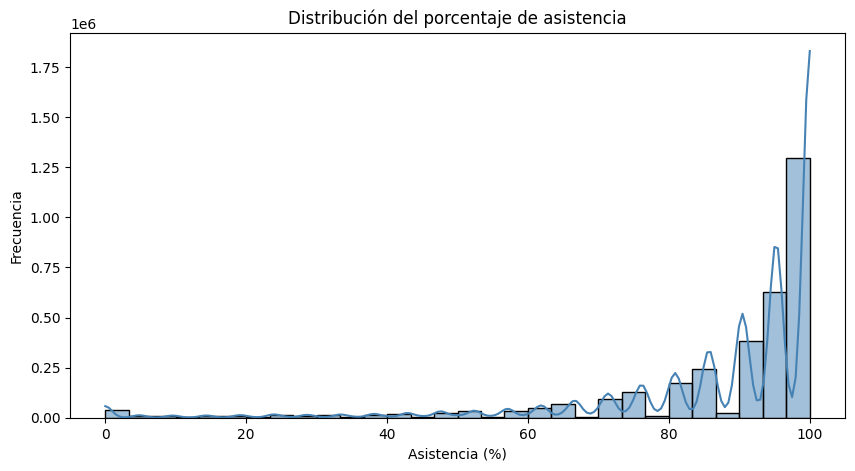

In [67]:
# Distribución general del porcentaje de asistencia
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.histplot(df_gold_final["ASISTENCIA_PCT"], bins=30, kde=True, color="steelblue")
plt.title("Distribución del porcentaje de asistencia")
plt.xlabel("Asistencia (%)")
plt.ylabel("Frecuencia")
plt.show()



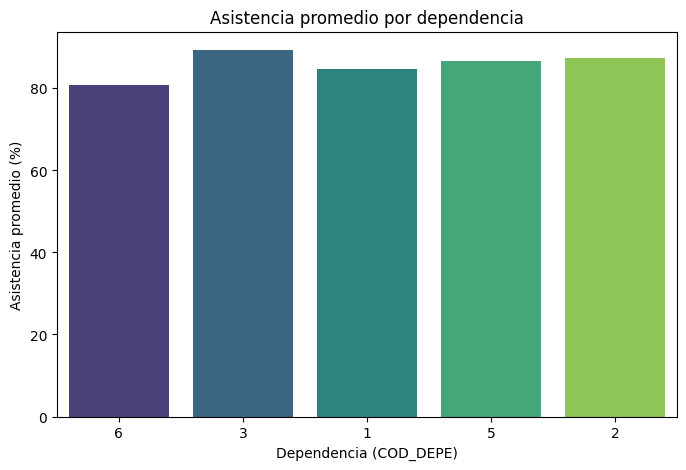

In [73]:
# Asistencia promedio por dependencia (COD_DEPE)
plt.figure(figsize=(8,5))
sns.barplot(
    data=df_gold_final,
    x="COD_DEPE",
    y="ASISTENCIA_PCT",
    hue="COD_DEPE",
    legend=False,
    estimator="mean",
    errorbar=None,
    palette="viridis"
)
plt.title("Asistencia promedio por dependencia")
plt.xlabel("Dependencia (COD_DEPE)")
plt.ylabel("Asistencia promedio (%)")
plt.show()


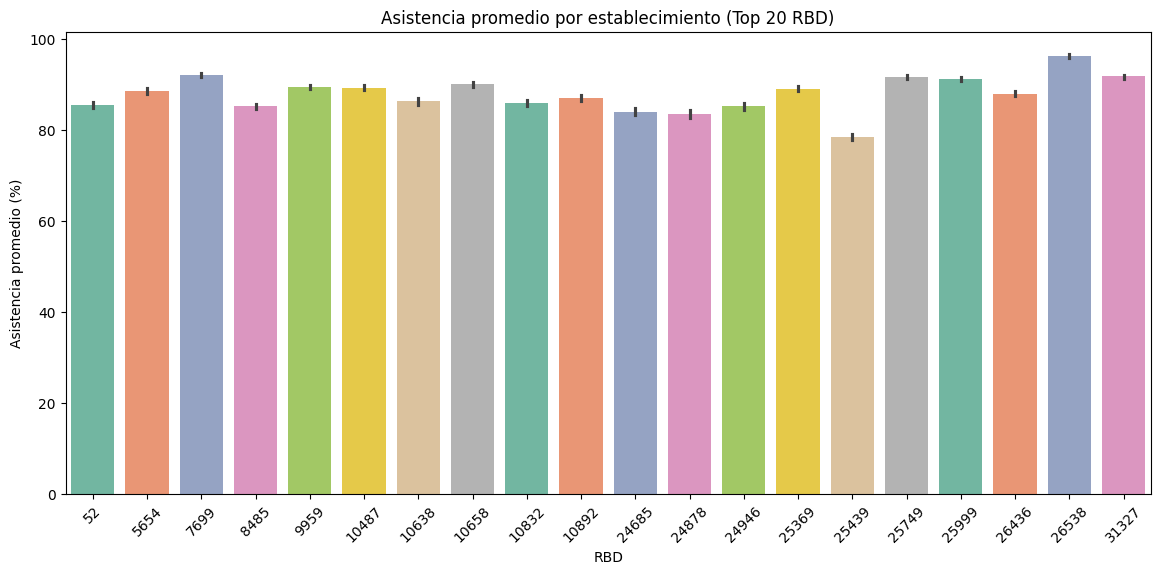

In [74]:
# Asistencia promedio por establecimiento (Top 20 RBD)
top_rbd = (
    df_gold_final["RBD"]
    .value_counts()
    .head(20)
    .index
)

plt.figure(figsize=(14,6))
sns.barplot(
    data=df_gold_final[df_gold_final["RBD"].isin(top_rbd)],
    x="RBD",
    y="ASISTENCIA_PCT",
    hue="RBD",
    legend=False,
    palette="Set2"
)
plt.title("Asistencia promedio por establecimiento (Top 20 RBD)")
plt.xlabel("RBD")
plt.ylabel("Asistencia promedio (%)")
plt.xticks(rotation=45)
plt.show()


/tmp/ipython-input-2181336853.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


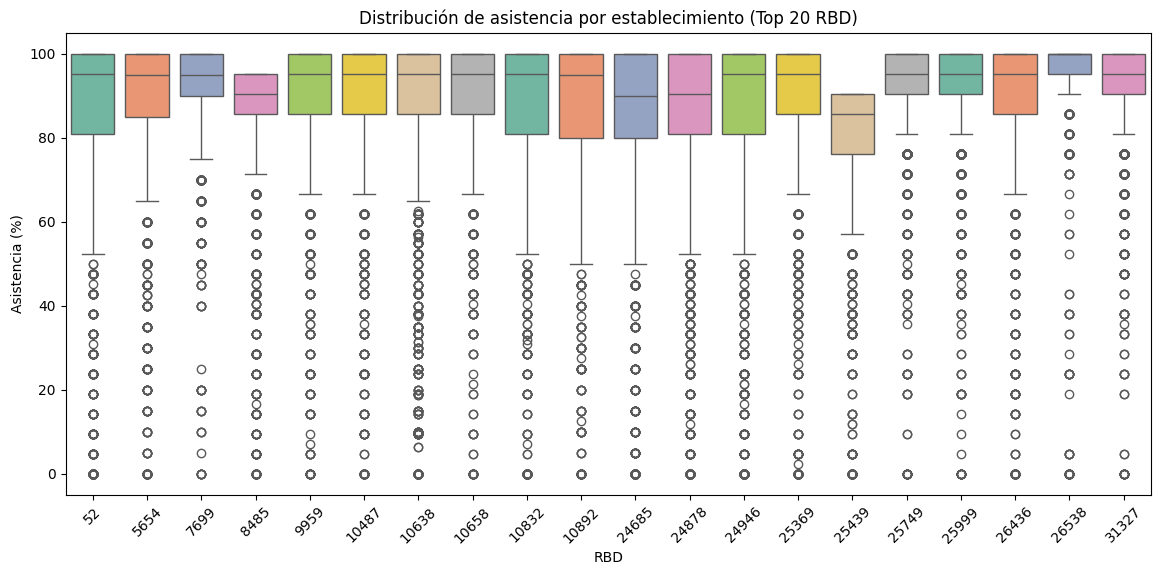

In [72]:
# Boxplot de asistencia por establecimiento (Top 20 RBD)
plt.figure(figsize=(14,6))
sns.boxplot(
    data=df_gold_final[df_gold_final["RBD"].isin(top_rbd)],
    x="RBD",
    y="ASISTENCIA_PCT",
    palette="Set2"
)
plt.title("Distribución de asistencia por establecimiento (Top 20 RBD)")
plt.xlabel("RBD")
plt.ylabel("Asistencia (%)")
plt.xticks(rotation=45)
plt.show()

